## EDA 및 전처리

### 데이터 살펴보기

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train = pd.read_csv('train.csv', index_col=0)
train.head()

,text,target
id,,
0,"\nThey were, and even if Washington might cons...",10
1,"We run ""SpaceNews & Views"" on our STAREACH BBS...",14
2,\n\n\nNot to worry. The Masons have been demo...,19
3,"Only Brendan McKay, or maybe ARF, would come t...",17
4,Help: I am running some sample problems from O...,5


In [ ]:
# 결측치 존재 여부를 확인해주는 함수
def check_missing_col(dataframe):
    missing_col = []
    counted_missing_col = 0
    for i, col in enumerate(dataframe.columns):
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            counted_missing_col += 1
            print(f'결측치가 있는 컬럼은: {col}입니다')
            print(f'해당 컬럼에 총 {missing_values}개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if counted_missing_col == 0:
        print('결측치가 존재하지 않습니다')
    return missing_col

missing_col = check_missing_col(train)

결측치가 존재하지 않습니다


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9233 entries, 0 to 9232
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    9233 non-null   object
 1   target  9233 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 216.4+ KB


In [ ]:
# 영어로 된 column들이 주를 이루고, target은 0~19까지 20개의 그룹이 존재
temp = train.target.unique()
np.sort(temp)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

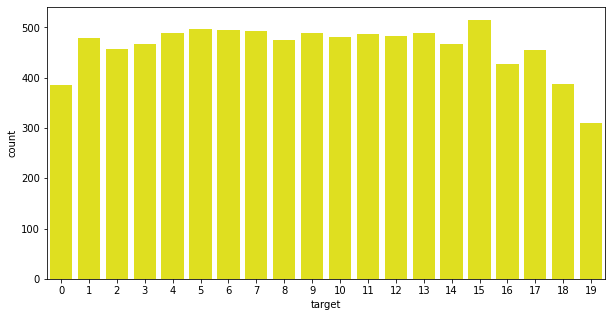

In [ ]:
# 그룹의 개수를 확인해본 결과, 그룹 별로 약간 차이가 있다는 것을 알 수 있다.
plt.figure(figsize=(10,5))
sns.countplot(x=train['target'], color='yellow')
plt.show()

In [ ]:
# 숫자로 살펴보면 다음과 같다
group_count = pd.DataFrame(train['target'].value_counts())
group_count.sort_values(by='target', ascending=False).head(10)

,target
15,515
5,496
6,494
7,493
13,490
9,490
4,490
11,488
12,483
10,482


#### test 데이터 살펴보기

In [ ]:
test = pd.read_csv('test.csv', index_col=0)
test.head()

,text
id,
0,\nThe VL-IDE Adapter can be much faster then t...
1,\n\nYeah. In a fire that reportedly burned ho...
2,":Judge: ""I grant you immunity from whatever ma..."
3,"I, too, put a corbin seat on my Hawk. I got t..."
4,\n\nDo I ever!!!!!! After 2 years of having h...


In [ ]:
check_missing_col(test)

결측치가 존재하지 않습니다


[]

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9233 entries, 0 to 9232
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    9233 non-null   object
dtypes: object(1)
memory usage: 144.3+ KB


### 텍스트 전처리1

In [ ]:
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
import re 

def clean_text(texts): 
  corpus = [] 
  for i in range(0, len(texts)): 

    review = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"\n\]\[\>]', '',texts[i]) #@%*=()/+ 와 같은 문장부호 제거
    review = re.sub(r'\d+','', review)#숫자 제거
    review = review.lower() #소문자 변환
    review = re.sub(r'\s+', ' ', review) #extra space 제거
    review = re.sub(r'<[^>]+>','',review) #Html tags 제거
    review = re.sub(r'\s+', ' ', review) #spaces 제거
    review = re.sub(r"^\s+", '', review) #space from start 제거
    review = re.sub(r'\s+$', '', review) #space from the end 제거
    review = re.sub(r'_', ' ', review) #space from the end 제거
    corpus.append(review) 
  
  return corpus

In [ ]:
train['text'] = clean_text(train['text'])
train.head()

,text,target
id,,
0,they were and even if washington might conside...,10
1,we run spacenews views on our stareach bbs a l...,14
2,not to worry the masons have been demonized an...,19
3,only brendan mckay or maybe arf would come to ...,17
4,help i am running some sample problems from or...,5


In [ ]:
test['text'] = clean_text(test['text'])
test.head()

,text
id,
0,the vlide adapter can be much faster then the ...
1,yeah in a fire that reportedly burned hotter t...
2,judge i grant you immunity from whatever may b...
3,i too put a corbin seat on my hawk i got the s...
4,do i ever after years of having health problem...


### 텍스트 전처리 2

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2),
                             stop_words='english',
                             )

vectorizer.fit(np.array(train["text"]))

X_train = vectorizer.transform(train["text"])
y_train = train['target']
X_test = vectorizer.transform(test["text"])

In [ ]:
print(f"shape of X_train: {X_train.shape}")
print(f"shape of X_test: {X_test.shape}")

shape of X_train: (9233, 791687)
shape of X_test: (9233, 791687)


### 불균형데이터 처리

In [ ]:
from imblearn.under_sampling import *
from imblearn.over_sampling import *
from imblearn.combine import *

In [ ]:
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_train, y_train)

In [ ]:
print('the shape of X_resampled: ', X_resampled.shape)
print('the shape of y_resampled: ', y_resampled.shape)

the shape of X_resampled:  (10300, 791687)
the shape of y_resampled:  (10300,)


In [ ]:
X_train = X_resampled
y_train = y_resampled

## 모델 돌리기

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
model = MLPClassifier(activation = 'relu',
                      solver = 'adam',
                      alpha = 0.0005,
                      learning_rate = 'adaptive',
                      learning_rate_init = 0.001,
                      early_stopping=True,
                      random_state=42
                      )

In [ ]:
model.fit(X_train, y_train)

MLPClassifier(alpha=0.0005, early_stopping=True, learning_rate='adaptive',
              random_state=42)

### 파일 제출하기

In [ ]:
submission = pd.read_csv('sample_submission.csv')

In [ ]:
submission

,id,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
9228,9228,0
9229,9229,0
9230,9230,0
9231,9231,0


In [ ]:
pred = model.predict(X_test)
submission['target'] = pred

In [ ]:
submission

,id,target
0,0,3
1,1,16
2,2,11
3,3,8
4,4,7
...,...,...
9228,9228,16
9229,9229,1
9230,9230,4
9231,9231,0


In [ ]:
submission.to_csv('mlpclassifier1.csv', index = False)